# Generate fake data on a relativistic DNS, make a mass-mass diagram

As an example we use the double neutron star (PSR B1534+12).  We generate fake data, fit post-Keplerian parameters, and
plot a mass-mass diagram to illustrate the overlapping constraints

This reproduces a version of Figure 9 from [Fonseca et al. (2014, ApJ, 787, 82)](https://ui.adsabs.harvard.edu/abs/2014ApJ...787...82F/abstract)

In [1]:
from astropy import units as u, constants as c
import astropy.time
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import io

import pint.fitter
from pint.models import get_model
import pint.derived_quantities
import pint.simulation
import pint.logging

# setup the logging
pint.logging.setup(level="INFO")

1

Some helper functions for plotting

In [2]:
def plot_contour(mp, mc, quantity, target, uncertainty, color, nsigma=3, **kwargs):
    """Plot two lines at +/-nsigma * the uncertainty to illustrate a constraint.

    Parameters
    ----------
    mp : astropy.units.Quantity
        array of pulsar masses (x-axis)
    mc : astropy.units.Quantity
        array of companion masses (y-axis)
    quantity : astropy.units.Quantity
        2D array of the prediction as a function of mp and mc. Shape is (len(mc), len(mp))
    target : astropy.units.Quantity
        best-fit value of the prediction (say from a PINT fit).
    uncertainty : astropy.units.Quantity
        uncertainty on that best-fit
    color : str
        color string for the lines
    nsigma : float, optional
        factor times the uncertainty for the lines (default = 3)

    Returns
    -------
    `~.contour.QuadContourSet`
        See :func:`matplotlib.pyplot.contour`
    """
    return plt.contour(
        mp.value,
        mc.value,
        quantity.value,
        [(target - nsigma * uncertainty).value, (target + nsigma * uncertainty).value],
        colors=color,
        **kwargs,
    )


def plot_fill(
    mp, mc, quantity, target, uncertainty, cmap, alpha=0.2, nsigma_max=3, **kwargs
):
    """Fill a region with a color map to illustrate a constraint.

    Outside of nsigma_max * uncertainty, constraint is not shown.

    Parameters
    ----------
    mp : astropy.units.Quantity
        array of pulsar masses (x-axis)
    mc : astropy.units.Quantity
        array of companion masses (y-axis)
    quantity : astropy.units.Quantity
        2D array of the prediction as a function of mp,mc.  Shape is (len(mc),len(mp))
    target : astropy.units.Quantity
        best-fit value of the prediction (say from a PINT fit).
    uncertainty : astropy.units.Quantity
        uncertainty on that best-fit
    cmap : str or `~matplotlib.colors.Colormap`
        matplotib colormap
    alpha : float, optional
        alpha for the color fill (default = 0.2)
    nsigma_max : float, optional
        factor times the uncertainty beyond which no constraint is shown (default = 3)

    Returns
    -------
    `~matplotlib.image.AxesImage`
        See :func:`matplotlib.pyplot.imshow`
    """
    z = np.fabs((quantity - target) / uncertainty)
    z[z >= nsigma_max] = np.nan
    plt.imshow(
        z,
        origin="lower",
        extent=(mp.value.min(), mp.value.max(), mc.value.min(), mc.value.max()),
        cmap=cmap,
        alpha=alpha,
        **kwargs,
    )


def get_plot_xy(mp, mc, quantity, target, uncertainty, mp_to_plot, nsigma=3):
    """A helper function to find the point in the quantity array that is nsigma * uncertainty away
    from the target value at mp=mp_to_plot

    returns mp,mc to plot a text label

    Parameters
    ----------
    mp : astropy.units.Quantity
        array of pulsar masses (x-axis)
    mc : astropy.units.Quantity
        array of companion masses (y-axis)
    quantity : astropy.units.Quantity
        2D array of the prediction as a function of mp,mc.  Shape is (len(mc),len(mp))
    target : astropy.units.Quantity
        best-fit value of the prediction (say from a PINT fit).
    uncertainty : astropy.units.Quantity
        uncertainty on that best-fit
    mp_to_plot : astropy.units.Quantity
        x-axis value at which to interpolate
    nsigma : float, optional
        factor times the uncertainty for the lines (default = 3)

    Returns
    -------
    mp_to_plot : astropy.units.Quantity
    mc_to_plot : astropy.units.Quantity
    """
    z = (quantity - target) / uncertainty
    j = np.abs(mp - mp_to_plot).argmin()
    i = np.argmin(np.abs(z[:, j] - nsigma))
    return mp[j], mc[i]

In [3]:
# par file for B1534+12 from ATNF catalog
# basically from Fonseca, Stairs, & Thorsett (2014)
# https://ui.adsabs.harvard.edu/abs/2014ApJ...787...82F/abstract
# except
# * I removed the DM1/DM2 parameters (they were causing errors without a DMEPOCH)
# * I removed RM (PINT couldn't understand it)
# * I removed EPHVER 2 (PINT doesn't do anything with it)
# * I added EPHEM DE440
test_par = """
PSRJ            J1537+1155
RAJ             15:37:09.961730               3.000e-06
DECJ            +11:55:55.43387               6.000e-05
DM              11.61944                      2.000e-05
PEPOCH          52077
F0              26.38213277689397             1.100e-13
F1              -1.686097E-15                 2.000e-21
PMRA            1.482                         7.000e-03
PMDEC           -25.285                       1.200e-02
F2              1.70E-29                      1.100e-30
BINARY          DD
PB              0.420737298879                2.000e-12
ECC             0.27367752                    7.000e-08
A1              3.7294636                     6.000e-07
T0              52076.827113263               1.100e-08
OM              283.306012                    1.200e-05
OMDOT           1.7557950                     1.900e-06
PBDOT           -0.1366E-12                   3.000e-16
#RM              10.6                          2.000e-01
PX              0.86                          1.800e-01
#DM1             -0.000653                     9.000e-06
F3              -1.6E-36                      2.000e-37
#DM2             0.00031                       1.000e-05
GAMMA           2.0708E-03                    5.000e-07
SINI            0.9772                        1.600e-03
M2              1.35                          5.000e-02
UNITS           TDB
EPHEM           DE440
"""

In [4]:
# PINT wants to read from a file.  So make a file-like object
# out of the string
f = io.StringIO(test_par)

In [5]:
# load the model into PINT
m = get_model(f)

In [6]:
# roughly the parameters from Fonseca, Stairs, Thorsett (2014)
tstart = astropy.time.Time(1990.25, format="jyear")
tstop = astropy.time.Time(2014, format="jyear")
# this is the error on each TOA
error = 5 * u.us
# this is a guess
Ntoa = 1000
# make the new TOAs.  Note that even though `error` is passed, the TOAs
# start out perfect
tnew = pint.simulation.make_fake_toas_uniform(
    tstart.mjd * u.d, tstop.mjd * u.d, Ntoa, model=m, obs="ARECIBO", error=error
)
# So we have to still add in some noise
tnew.adjust_TOAs(astropy.time.TimeDelta(np.random.normal(size=len(tnew)) * error))

In [7]:
# construct a PINT fitter object with the model and simulated TOAs
fit = pint.fitter.WLSFitter(tnew, m)

In [8]:
# fit for all of the PK parameters
# by default because the par file doesn't have parameters listed as free
# all of the other parameters will be frozen
# so this will be an underestimate of the true uncertainties (because of covariances)
fit.model.GAMMA.frozen = False
fit.model.PBDOT.frozen = False
fit.model.OMDOT.frozen = False
fit.model.M2.frozen = False
fit.model.SINI.frozen = False
fit.fit_toas()

1054.7110089296632448

In [9]:
# look at the output.  Hopefully, since these are simulated TOAs
# the fit will be good.  And indeed we see a reduced chi^2 very close to 1
try:
    fit.print_summary()
except ValueError as e:
    print(f"Unexpected exception: {e}")

Fitted model using weighted_least_square method with 5 free parameters to 1000 TOAs
Prefit residuals Wrms = 5.1466401323828945 us, Postfit residuals Wrms = 5.134956204607939 us
Chisq = 1054.711 for 994 d.o.f. for reduced Chisq of 1.061

PAR                   Prefit                  Postfit            Units
============== ==================== ============================ =====
PSR                      J1537+1155 J1537+1155                   None
EPHEM                         DE440 DE440                        None
CLOCK                               TT(TAI)                      None
UNITS                           TDB TDB                          None
START                                                    47983.3 d 
FINISH                                                     56658 d 
BINARY                           DD DD                           None
DILATEFREQ                        N                              None
DMDATA                            N                              

The value of $\dot P_B$ is biased because of kinematic effects:
* Galactic acceleration
* The Shklovskii effect (from the source's proper motion)
We can correct for those, following [Nice & Taylor (1995, ApJ, 441, 429)](https://ui.adsabs.harvard.edu/abs/1995ApJ...441..429N/abstract):
$$
\dot P_{B,{\rm obs}} = \dot P_{B,{\rm true}} + P_B \left(\frac{\vec{a} \cdot \vec{n}}{c} + \frac{\mu^2 d}{c}\right)
$$
(Eqn. 2 from that paper), where $\vec{a} \cdot \vec{n}$ is the component of Galactic acceleration along the line of sight, $d$ is the distance, and $\mu$ is the proper motion. So the first term there is the Galactic acceleration term, and the second is the Shklovskii term.

For the former we need to know the Galactic potential.  As a simplifying assumption we will assume a flat rotation curve, which gives us:
$$
\vec{a} \cdot \vec{n} = -\cos b \left(\frac{\Theta_0^2}{R_0}\right) \left(\cos l + \frac{\beta}{\sin^2 l + \beta^2}\right)
$$
where
$$
\beta = \frac{d}{R_0} \cos b - \cos l
$$
$(l,b)$ are the Galactic coordinates, $\Theta_0$ is the rotational velocity, and $R_0$ is the distance to the Galactic center (Eqn. 5 in the paper above).

For both of these we need to know the distance.

In [10]:
# get the distance from the parallax. Note that this is crude (the inversion is not good at low S/N)
d = m.PX.quantity.to(u.kpc, equivalencies=u.parallax())
d_err = d * (m.PX.uncertainty / m.PX.quantity)
print(f"distance: {d:.2f} +/- {d_err:.2f}")

distance: 1.16 kpc +/- 0.24 kpc


In [11]:
# The PBDOT measurements need correction for kinematic effects
# both Shklovskii acceleration and Galactic acceleration
# do those here

# for Galactic acceleration, need to know the size and speed of the Milky Way
# GRAVITY collaboration 2019
# https://ui.adsabs.harvard.edu/abs/2019A&A...625L..10G
R0 = 8.178 * u.kpc
Theta0 = 220 * u.km / u.s

# We will assume a flat rotation curve: not the best but probably OK
b = m.coords_as_GAL().b
l = m.coords_as_GAL().l
beta = (d / R0) * np.cos(b) - np.cos(l)
# Nice & Taylor (1995), Eqn. 5
# https://ui.adsabs.harvard.edu/abs/1995ApJ...441..429N/abstract
a_dot_n = (
    -np.cos(b) * (Theta0**2 / R0) * (np.cos(l) + beta / (np.sin(l) ** 2 + beta**2))
)
# Galactic acceleration contribution to PBDOT
PBDOT_gal = (fit.model.PB.quantity * a_dot_n / c.c).decompose()
# Shklovskii contribution
PBDOT_shk = (fit.model.PB.quantity * pint.utils.pmtot(m) ** 2 * d / c.c).to(
    u.s / u.s, equivalencies=u.dimensionless_angles()
)
# the uncertainty from the Galactic acceleration isn't included
# but it's much smaller than the Shklovskii term so we'll ignore it
PBDOT_err = (fit.model.PB.quantity * pint.utils.pmtot(m) ** 2 * d_err / c.c).to(
    u.s / u.s, equivalencies=u.dimensionless_angles()
)
print(f"PBDOT_gal = {PBDOT_gal:.2e}, PBDOT_shk = {PBDOT_shk:.2e} +/- {PBDOT_err:.2e}")

PBDOT_gal = 1.20e-15, PBDOT_shk = 6.59e-14 +/- 1.38e-14


(array([1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 [Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4'),
  Text(0, 1.6, '1.6'),
  Text(0, 1.8, '1.8'),
  Text(0, 2.0, '2.0')])

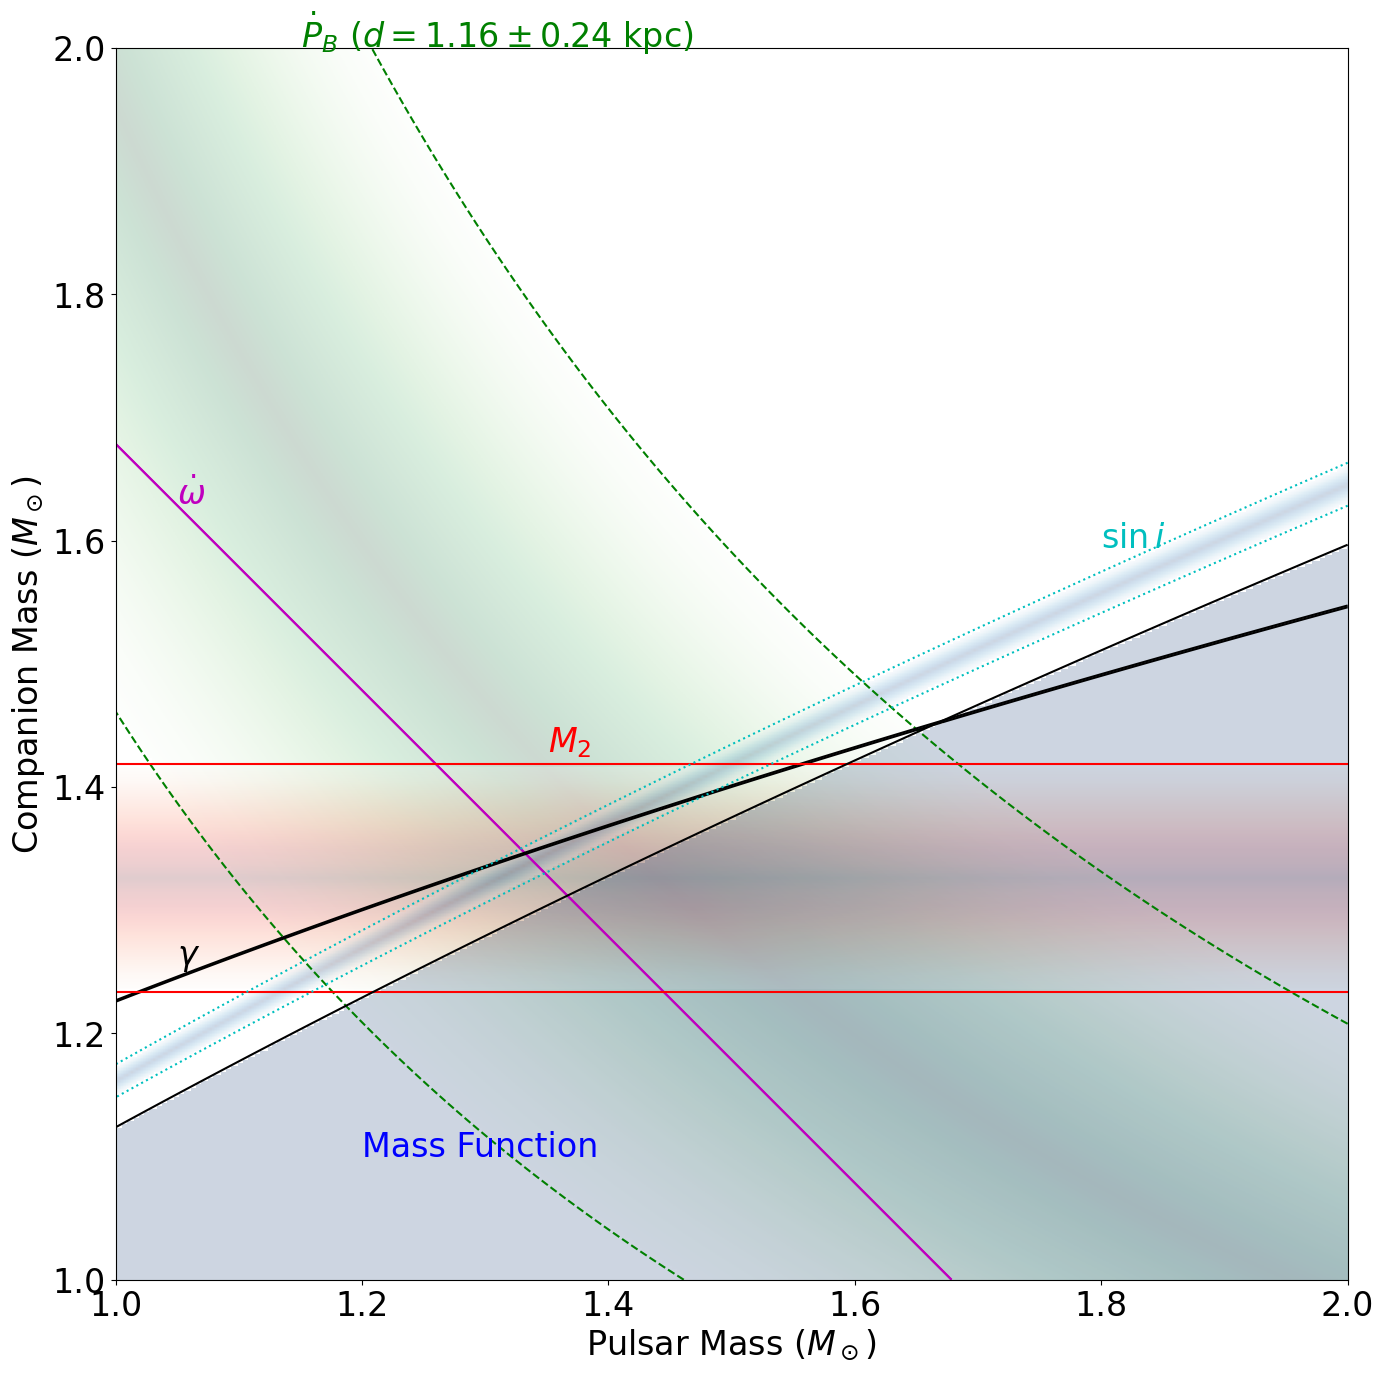

In [12]:
# make a dense grid of Mp,Mc values to compute all of the PK parameters
mp = np.linspace(1, 2, 500) * u.Msun
mc = np.linspace(1, 2, 400) * u.Msun
Mp, Mc = np.meshgrid(mp, mc)
omdot_pred = pint.derived_quantities.omdot(
    Mp, Mc, fit.model.PB.quantity, fit.model.ECC.quantity
)
pbdot_pred = pint.derived_quantities.pbdot(
    Mp, Mc, fit.model.PB.quantity, fit.model.ECC.quantity
)
gamma_pred = pint.derived_quantities.gamma(
    Mp, Mc, fit.model.PB.quantity, fit.model.ECC.quantity
)
sini_pred = (
    pint.derived_quantities.mass_funct(fit.model.PB.quantity, fit.model.A1.quantity)
    * (Mp + Mc) ** 2
    / Mc**3
) ** (1.0 / 3)

plt.figure(figsize=(16, 16))
fontsize = 24

nsigma = 3

# OMDOT
# for each quantity we plot contours at +/-3 sigma compared to the best fit
# we also (optionally) plot a colored fill if there is enough space
# and then try to label it
# (a little fudging is required for that)
plot_contour(
    mp, mc, omdot_pred, fit.model.OMDOT.quantity, fit.model.OMDOT.uncertainty, "m"
)
# this one doesn't have enough space to really display
# plot_fill(mp, mc, omdot_pred, fit.model.OMDOT.quantity,fit.model.OMDOT.uncertainty, cmap=cm.Reds_r)
x, y = get_plot_xy(
    mp,
    mc,
    omdot_pred,
    fit.model.OMDOT.quantity,
    fit.model.OMDOT.uncertainty,
    1.05 * u.Msun,
    3,
)
plt.text(x.value, y.value, "$\dot \omega$", fontsize=fontsize, color="m")

# PBDOT
# make sure we correct it for the kinematic terms
PBDOT_corr = fit.model.PBDOT.quantity - PBDOT_gal - PBDOT_shk
# also add the error from the distance uncertainty in quadrature
PBDOT_uncertainty = np.sqrt(fit.model.PBDOT.uncertainty**2 + PBDOT_err**2)
plot_contour(mp, mc, pbdot_pred, PBDOT_corr, PBDOT_uncertainty, "g", linestyles="--")
plot_fill(mp, mc, pbdot_pred, PBDOT_corr, PBDOT_uncertainty, cmap=cm.Greens_r)
x, y = get_plot_xy(mp, mc, pbdot_pred, PBDOT_corr, PBDOT_uncertainty, 1.15 * u.Msun, -3)
plt.text(
    x.value,
    y.value,
    "$\dot P_B$ ($d=%.2f \pm %.2f$ kpc)" % (d.value, d_err.value),
    fontsize=fontsize,
    color="g",
)

# GAMMA
plot_contour(
    mp, mc, gamma_pred, fit.model.GAMMA.quantity, fit.model.GAMMA.uncertainty, "k"
)
# plot_fill(mp, mc, gamma_pred, fit.model.GAMMA.quantity,fit.model.GAMMA.uncertainty, cmap=cm.Greens_r)
x, y = get_plot_xy(
    mp,
    mc,
    gamma_pred,
    fit.model.GAMMA.quantity,
    fit.model.GAMMA.uncertainty,
    1.05 * u.Msun,
    3,
)
plt.text(x.value, y.value + 0.01, "$\gamma$", fontsize=fontsize, color="k")

# M2
plot_contour(mp, mc, Mc, fit.model.M2.quantity, fit.model.M2.uncertainty, "r")
plot_fill(mp, mc, Mc, fit.model.M2.quantity, fit.model.M2.uncertainty, cmap=cm.Reds_r)
x, y = get_plot_xy(
    mp, mc, Mc, fit.model.M2.quantity, fit.model.M2.uncertainty, 1.35 * u.Msun, 3
)
plt.text(x.value, y.value + 0.01, "$M_2$", fontsize=fontsize, color="r")

# SINI
plot_contour(
    mp,
    mc,
    sini_pred,
    fit.model.SINI.quantity,
    fit.model.SINI.uncertainty,
    "c",
    linestyles=":",
)
plot_fill(
    mp,
    mc,
    sini_pred,
    fit.model.SINI.quantity,
    fit.model.SINI.uncertainty,
    cmap=cm.Blues_r,
)
x, y = get_plot_xy(
    mp,
    mc,
    sini_pred,
    fit.model.SINI.quantity,
    fit.model.SINI.uncertainty,
    1.8 * u.Msun,
    -3,
)
plt.text(x.value, y.value + 0.02, "$\sin i$", fontsize=fontsize, color="c")

# Mass function
plt.contour(
    mp.value,
    mc.value,
    pint.derived_quantities.mass_funct2(Mp, Mc, 90 * u.deg).value,
    [
        pint.derived_quantities.mass_funct(
            fit.model.PB.quantity, fit.model.A1.quantity
        ).value
    ],
    colors="k",
)
z = (
    pint.derived_quantities.mass_funct2(Mp, Mc, 90 * u.deg).value
    - pint.derived_quantities.mass_funct(
        fit.model.PB.quantity, fit.model.A1.quantity
    ).value
)
z[z > 0] = np.nan
z[z <= 0] = 1
plt.imshow(
    z,
    origin="lower",
    extent=(mp.value.min(), mp.value.max(), mc.value.min(), mc.value.max()),
    cmap=cm.Blues,
    vmin=0,
    vmax=1,
    alpha=0.2,
)
# plt.contour(mp.value,mc.value,gamma_pred.value,[(f.model.GAMMA.quantity - 3*f.model.GAMMA.uncertainty).value,(f.model.GAMMA.quantity + 3*f.model.GAMMA.uncertainty).value])
# plt.contour(mp.value,mc.value,pbdot_pred.value,[(f.model.PBDOT.quantity - 3*f.model.PBDOT.uncertainty).value,(f.model.PBDOT.quantity + 3*f.model.PBDOT.uncertainty).value])
plt.text(1.2, 1.1, "Mass Function", fontsize=fontsize, color="b")

plt.xlabel("Pulsar Mass $(M_\\odot)$", fontsize=fontsize)
plt.ylabel("Companion Mass $(M_\\odot)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.savefig('PSRB1534_massmass.png')